In [1]:
%matplotlib notebook

In [2]:
from pydub import AudioSegment
import tqdm
import json
import os
import statistics
import argparse
from utils import get_msecs, video_to_wav, extract_features, read_audio_file, get_wav
from models import model_torch
import librosa
import torch
import numpy as np

import sed_vis
import dcase_util
from utils import video_to_wav

def librosa_get_data_chunk(X, sr, json_data, labels_exist=True):
    labeled_wav_list = []
    if labels_exist:
        for descr in json_data['sound_results']:
            st_time = int(get_msecs(descr['start_time']) * sr / 1000)
            end_time = int(get_msecs(descr['end_time'])  * sr / 1000)
            label = descr['sound_type']
            labeled_wav_list.append((X[st_time:end_time+1], label, get_msecs(descr['start_time']), get_msecs(descr['end_time'])))
    else:
        data_length = len(X)*1000//sr
        for time in range(0, data_length-1000, 1000):
            st_time = int(time * sr / 1000)
            end_time = int((time+1000) * sr / 1000)
            label = None
            labeled_wav_list.append((X[st_time:end_time+1], label, time, time+1000))

    return labeled_wav_list
def get_model(features):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Executing model on:", device)
    model = model_torch(40, 9)

    print("Loading model weights...")
    PATH = "../checkpoint/torch_model.pt"
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    prev_loss = checkpoint['loss']
    model.to(device)
    model.eval()
    print("Loading finished.")
    return model, device

def get_time(start_time, end_time):
    st_secs = start_time//1000
    ed_secs = end_time//1000
    return st_secs, ed_secs

def _convert_to_dcase_format(ann_dict):
    ev_list = []
    sound_results = ann_dict['sound_results']

    for ev in sound_results:
        d = {}
        d['onset'], d['offset'] = get_time(ev['start_time'], ev['end_time'])
        d['file_name'] = ann_dict['file_name']
        d['event_label'] = ev['sound_type']
        ev_list.append(d)

    return ev_list

def visualize(pred, gt, path):
    truth = _convert_to_dcase_format(gt)
    prediction = _convert_to_dcase_format(pred)
    
    audio_container = dcase_util.containers.AudioContainer().load(path, mono=True)

    truth_list = dcase_util.containers.MetaDataContainer(truth)
    pred_list = dcase_util.containers.MetaDataContainer(prediction)
    event_lists = {'reference': truth_list,
                'estimated': pred_list}
    """
    Visualize the predicted and ground_truth sound events
    """
    vis = sed_vis.visualization.EventListVisualizer(event_lists=event_lists,
                                                    audio_signal=audio_container.data,
                                                    sampling_rate=audio_container.fs)
    vis.show()
    #vis.save('../figures/prediction_visualization.png')
    return

def predict(args):
    labels = None
    if args.gt != None:
        print("Loading json label files...")
        path = args.gt
        with open(path) as js_file:
            js_data = json.load(js_file)
            print("JS_data of ", js_data['file_name'], 'is loaded')
            labels = js_data

    print("Loading input audio file...")
    path = args.input
    #(audio, _) = get_wav(path)
    X, sr = read_audio_file(path)
    #print('Extracted.', len(audio))
    print("shape and sr:", X.shape, sr)
    classes = np.load('./classes.npy', allow_pickle=True)
    for it in range(len(classes)):
        cl = classes[it]
        classes[it] = cl.replace('-','/')
    print("\nClasses are ", classes, '\n')
    if labels != None:
        print("Dividing whole video into chunks with GT labels...")
        labeled_wav = None
        labeled_wav = librosa_get_data_chunk(X, sr, labels)
    else:
        print("Dividing whole video into chunks...")
        labeled_wav = None
        labeled_wav = librosa_get_data_chunk(X, sr, labels, labels_exist=False)
    #load pre-tained model
    model, device = get_model(40)
    #prediction json dictionary
    json_dict = {}
    json_dict["file_name"] = args.input.split('/')[-1]
    json_dict["sound_results"] = list()
    #ground truth json dictionary
    gt_labels = {}
    gt_labels["file_name"] = args.input.split('/')[-1]
    gt_labels["sound_results"] = list()
    for sample in tqdm.tqdm(labeled_wav):
        if len(sample[0]) < 1000:
            continue
        features = extract_features(X, sr)
        X_test = np.expand_dims(np.array(features), axis=0)
        x_testcnn = np.expand_dims(X_test, axis=2)
        y_pred = model(torch.from_numpy(x_testcnn).float().to(device)).detach().cpu().numpy()
        predicted = np.argmax(y_pred, 1)
        js_entry = {}
        js_entry["start_time"] = sample[-2]
        js_entry["end_time"] =  sample[-1]
        js_entry["sound_type"] = classes[predicted][0]
        json_dict["sound_results"].append(js_entry)
        
        if labels != None and js_entry["sound_type"] != sample[1]:
            js_entry2 = {"start_time": sample[-2], "end_time": sample[-1], "sound_type": sample[1]}
            gt_labels["sound_results"].append(js_entry2)
        else:
            js_entry2 = {"start_time": sample[-2], "end_time": sample[-1], "sound_type": 'unlabeled'}
            gt_labels["sound_results"].append(js_entry2)
    save_directory = args.output[:args.output.rfind("/")]
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    with open(args.output, 'w') as outfile:
        json.dump(json_dict, outfile, indent=2)
    print("Predictions are written to JSON file!")
    
    with open(save_directory+'/'+'gt_labels.json', 'w') as outfile:
        json.dump(gt_labels, outfile, indent=2)
    print("GT_labels are written to JSON file!")

    return json_dict, gt_labels, path
   

In [3]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run data preprocessing.")
    parser.add_argument('--checkpoint', nargs='?', default='checkpoint/torch_model.pt',
	                    help="Path to the model's checkpoint.")
    parser.add_argument('--input', nargs='?', default=None,
	                    help='Path to input video.') 
    parser.add_argument('--gt', nargs='?', default=None,
	                    help='Path to JSON file with GT labels.')
    parser.add_argument('--output', nargs='?', default=None,
	                    help='Path to output JSON file with predicted labels.')
    parser.add_argument('--sr', nargs='?', default=48000,
	                    help='Sampling rate.')
    return parser.parse_args()

In [8]:
import sys,os,argparse
#input wav file and prediction output
sys.argv = ['demo.py', '--input', '../test_kor.mp4', '--output', '../predictions/prediction.json']

In [9]:
args = parse_args()

In [10]:
if args.input[-3:] != 'wav':
    print("Video file is received! Converting to wav...")
    args.input = video_to_wav(args.input, save_directory=args.input.rsplit('/', 1)[0]+'/', video_format=args.input.rsplit('.', 1)[1])
    print("Conversion finished! New wav file: ", args.input)

Video file is received! Converting to wav...
Conversion finished! New wav file:  ../test_kor.wav


In [11]:
print("Inference stage...")
json_dict, gt_labels, path = predict(args)

Inference stage...
Loading input audio file...


  0%|          | 0/666 [00:00<?, ?it/s]

shape and sr: (29412352,) 44100

Classes are  ['background_music' 'clapping' 'crashing' 'door bell' 'knocking'
 'laughing' 'opening/closing doors' 'shouting ' 'speaking'] 

Dividing whole video into chunks...
Executing model on: cuda:0
Net(
  (process_conv): Sequential(
    (0): Conv1d(40, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (process_lin):

100%|██████████| 666/666 [21:21<00:00,  1.92s/it]

Predictions are written to JSON file!
GT_labels are written to JSON file!


({'file_name': 'test_kor.wav',
  'sound_results': [{'start_time': 0,
    'end_time': 1000,
    'sound_type': 'background_music'},
   {'start_time': 1000, 'end_time': 2000, 'sound_type': 'background_music'},
   {'start_time': 2000, 'end_time': 3000, 'sound_type': 'background_music'},
   {'start_time': 3000, 'end_time': 4000, 'sound_type': 'background_music'},
   {'start_time': 4000, 'end_time': 5000, 'sound_type': 'background_music'},
   {'start_time': 5000, 'end_time': 6000, 'sound_type': 'background_music'},
   {'start_time': 6000, 'end_time': 7000, 'sound_type': 'background_music'},
   {'start_time': 7000, 'end_time': 8000, 'sound_type': 'background_music'},
   {'start_time': 8000, 'end_time': 9000, 'sound_type': 'background_music'},
   {'start_time': 9000, 'end_time': 10000, 'sound_type': 'background_music'},
   {'start_time': 10000, 'end_time': 11000, 'sound_type': 'background_music'},
   {'start_time': 11000, 'end_time': 12000, 'sound_type': 'background_music'},
   {'start_time': 

Visualization of results...
Predictions and GT labels are loaded.
Begin visualization...


<IPython.core.display.Javascript object>


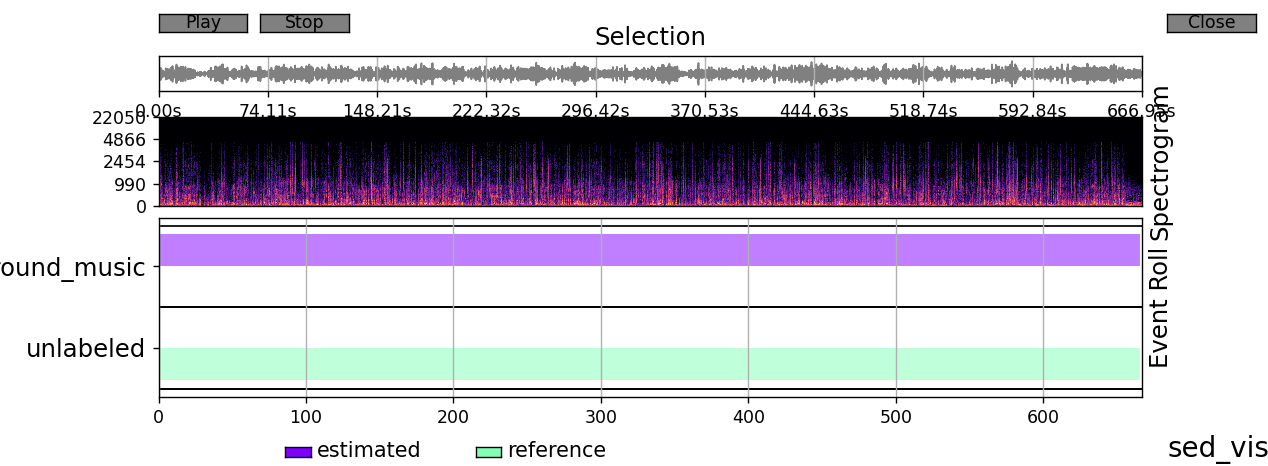

In [15]:
#Visualization
print("Visualization of results...")
with open(args.output) as js_file:
    json_dict = json.load(js_file)
save_directory = args.output[:args.output.rfind("/")]
with open(save_directory+'/'+'gt_labels.json') as js_file:
    gt_labels = json.load(js_file)
path = args.input
print("Predictions and GT labels are loaded.")
print("Begin visualization...")
visualize(json_dict, gt_labels, path)



In [13]:
args.output


'../predictions/prediction.json'